# Reference Active Inference Simulations

This script is used to generate figures of the paper "Chance-constrained Active Inference" (2021), by van de Laar, Senoz, Özçelikkale and Wymeersch, for publication in Neural Computation.

In [1]:
using Random
Random.seed!(51233) # Set random seed for reproducibility

using ForneyLab # Requires ForneyLab version 0.11.3
;

In [2]:
include("updates.jl") # Custom updates
include("environment.jl")
include("reference_agent.jl") # Include reference agent
include("helpers.jl") # FPlot functions

# Simulation parameters
N = 10000 # Total number of runs
L = 20 # Total simulation time

# Model parameters
T = 1 # Lookahead
v_w = 0.2 # Wind variance

# Design a goal prior s.t. the unsafe mass is epsilon
epsilon = 0.01
m_goal = 2.0 # Goal prior mean
v_goal = 0.18478 # Goal prior variance for epsilon=0.01

lambda = tiny # Control prior precision
; 

In [3]:
# Build agent model
fg = FactorGraph()

u  = Vector{Variable}(undef, T)
wu = Vector{Variable}(undef, T)
x  = Vector{Variable}(undef, T+1)

@RV [id=:x_t]        x[1] ~ placeholder(:x_hat_t) # Present state is observed
@RV [id=:u_t]        u[1] ~ GaussianMeanPrecision(0.0, lambda) # Control prior
@RV [id=:wu_t]      wu[1] ~ GaussianMeanVariance(u[1], v_w) # Include wind variance
@RV [id=:x_t_plus_1] x[2] = x[1] + wu[1] + placeholder(:m_w, index=1, var_id=:m_w_1) # Transition model
PointMassConstraint(u[1]) # Control constrained to point-mass

for k = 1:T-1
    GaussianMeanVariance(x[k+1], m_goal, v_goal) # Goal prior
    @RV [id=:u_t_plus_*k]     u[k+1] ~ GaussianMeanPrecision(0.0, lambda) # Constrol prior
    @RV [id=:wu_t_plus_*k]   wu[k+1] ~ GaussianMeanVariance(u[k+1], v_w) # Include wind variance
    @RV [id=:x_t_plus_*(k+1)] x[k+2] = x[k+1] + wu[k+1] + placeholder(:m_w, index=k+1, var_id=:m_w_*(k+1)) # Transition model
    PointMassConstraint(u[k+1]) # Control constrained to point-mass
end
GaussianMeanVariance(x[T+1], m_goal, v_goal) # Final goal prior
;

In [4]:
# Compile message passing algorithm
q = PosteriorFactorization(u, x, ids=[:U, :X]) # Factorization of the variational posterior
algo = messagePassingAlgorithm([u; x])
code = algorithmSourceCode(algo) # Generated algorithm source code
eval(Meta.parse(code)) # Load algorithm source code in scope
;

In [5]:
# Uncomment to inspect generated algorithm source code
# println(code)

# Control Law

The control law, which expresses the action as a function of current elevation, is generated here. The results are written to file and can be plotted in aggregate by the `plot_control_law` notebook. This script only generates the control law for the current agent parameter setting.

In [6]:
(infer, act) = initializeAgent()

x_hat = -1.0:0.01:5.0 # Trial elevations for rendering actions
K = length(x_hat)

a = Vector{Float64}(undef, K)
for k = 1:K
           infer(x_hat[k], zeros(T)) # Perform inference under wind mean of zero
    a[k] = act() # Extract corresponding action
end
;

In [7]:
using PyPlot

# Inspect the control law for the current agent parameters
plotControlLaw(x_hat, a)

# savefig("./figures/ctrl_reference_$(T)_$(m_goal)_$(v_goal)_$(v_w)_$(lambda).png", dpi=300)
;

In [8]:
using JLD

# Store control law (for current agent parameters) to file
save("figures/ctrl_reference_$(T)_$(m_goal)_$(v_goal)_$(v_w)_$(lambda).jld", "x_hat", x_hat, "a", a)
;

# Action-Perception Loop

The following implements the simulation where the agent interacts with the environment, following van de Laar & de Vries, "Simulating Active Inference Processes by Message Passing", Frontiers in Robotics and AI (2019).

In [9]:
using ProgressMeter

# Execute message passing
a = Matrix{Float64}(undef, L+1, N) # Actions
b = Matrix{Tuple}(undef, L+1, N) # Beliefs
x_hat = Matrix{Float64}(undef, L+1, N) # Observed states
w_hat = Matrix{Float64}(undef, L+1, N) # Observed wind

# For each run
@showprogress for n = 1:N
    # Reset world and agent
    (execute, observe) = initializeWorld() # (Re)set the environment
    (infer, act)       = initializeAgent() # (Re)set the agent

    # Action-perception loop
    for t = 0:L
        x_hat[t+1, n] = observe() # Observe the current elevation
        b[t+1, n]     = infer(x_hat[t+1, n], m_w.(t:t+T-1)) # Infer the new action given the future wind mean
        a[t+1, n]     = act() # Select an action
                        execute(a[t+1, n], m_w(t)) # Execute the action in the simulated environment
    end
end
;

Progress: 100%|█████████████████████████████████████████| Time: 0:03:49


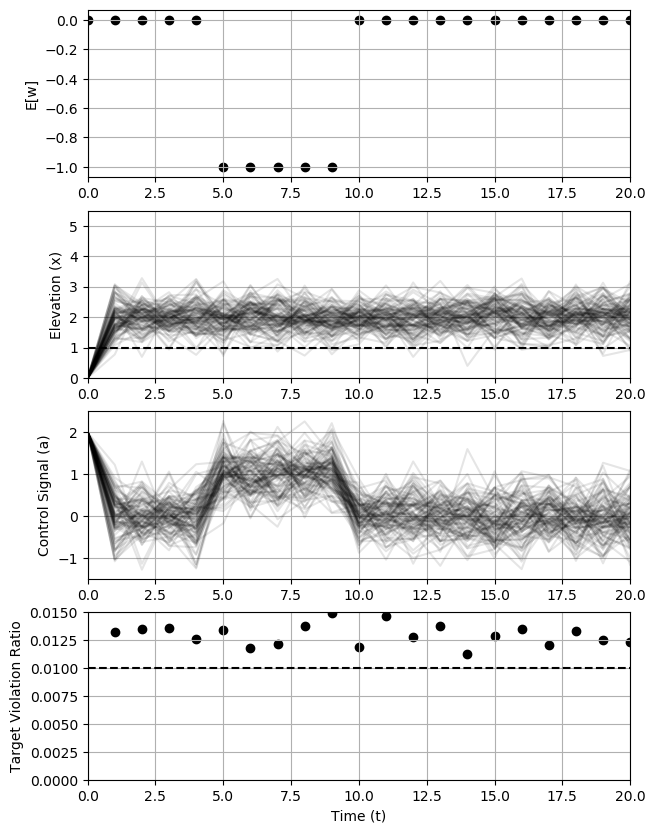

In [10]:
# Inspect a selection of simulated trajectories and plot the average violation ratio (for all trajectories)

per_n = ceil(Int, N/100) # Plot one in every per_n trajectories
E_avg = round(mean(sum(a.^2, dims=1)), digits=2) # Average quadratic cost of control (over all runs)

plotTrajectory(x_hat, a, per_n)

savefig("./figures/sim_reference_$(T)_$(m_goal)_$(v_goal)_$(N)_$(v_w)_$(lambda)_$(E_avg).png", dpi=300)
;

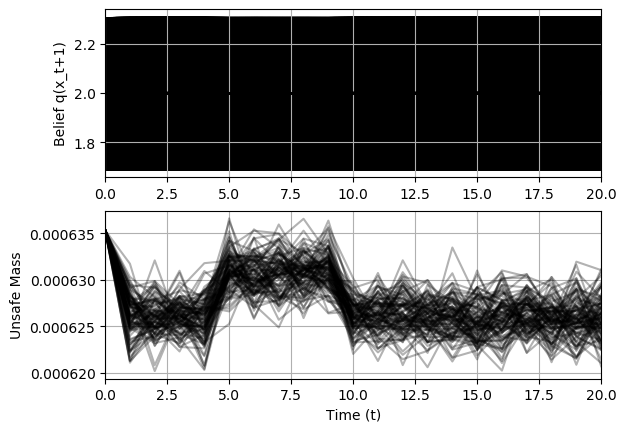

In [11]:
# Inspect the inferred belief and unsafe mass of the next future state per simulation.
# This plot can be used to verify the chance-constraints on future states.
# In the reference model the unsafe mass is expected to overshoot the threshold,
# because the chance constraint is not enforced on the posterior.

plotBeliefs(b)
;